# 从LAMOST DR12中选取M31天区天体样本

### 从Simbad中查询M31的中心坐标

- Simbad网址：https://simbad.cds.unistra.fr/simbad/sim-id?Ident=M31&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id
- 查询得到，M31坐标为 `ICRS coord. (ep=J2000) : 00 42 44.330 +41 16 07.50`，折合成赤经赤纬分别是 `10.6847 +41.2688`
- 另外，M31的视直径约为190角分，因此我们需要一张FOV大约为3度的图像。
- 查询DSS图像的数据，输入中心坐标等参数，设置点击下载得到图像：https://skyview.gsfc.nasa.gov/current/cgi/query.pl

In [1]:
# 读取DSS（Digital Sky Survey, 数字巡天）的R波段图像文件
from astropy.io import fits
hl = fits.open("m31/dss/skv2177985231060-DSS2Red.fits")
hl.info()

Filename: m31/dss/skv2177985231060-DSS2Red.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     142   (1200, 1200)   float32   


### 获取图像数据和WCS坐标

In [2]:
from astropy.wcs import WCS
import numpy as np
image_data = np.log10(hl[0].data)  # 获取图像数据数组
header = hl[0].header    # 获取FITS头信息（含坐标系统）

# 创建世界坐标系统（WCS）对象
wcs = WCS(header)

# 提取坐标轴标签（如赤经/赤纬）
ra_label = "RA (J2000)"
dec_label = "Dec (J2000)"

/var/folders/2y/b85hkd6543v71b_2f08ycrp00000gn/T/ipykernel_13410/3333741194.py:3: RuntimeWarning: invalid value encountered in log10
  image_data = np.log10(hl[0].data)  # 获取图像数据数组


### 画出DSS图像

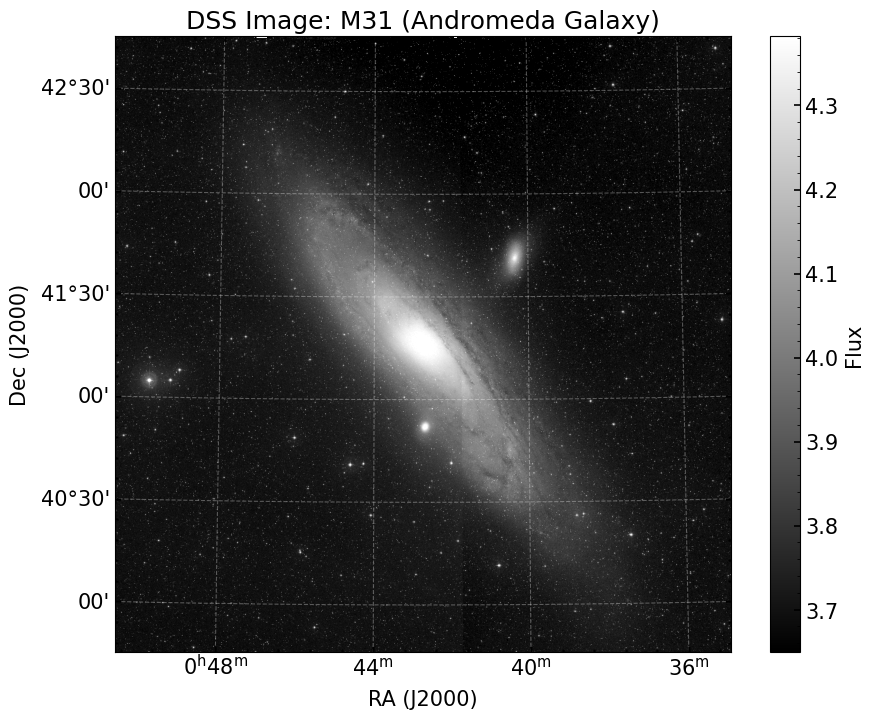

In [3]:
import matplotlib.pyplot as plt
from laspec.mpl import set_cham
set_cham(latex=False)

# 创建带天文坐标的绘图画布
fig = plt.figure(figsize=(10, 8), dpi=100)
ax = fig.add_subplot(111, projection=wcs)

# 绘制DSS图像（使用灰度色图，调整对比度）
im = ax.imshow(
    image_data,
    cmap='gray',
    origin='lower',
    vmin=np.nanpercentile(image_data, 5),  # 增强暗部细节
    vmax=np.nanpercentile(image_data, 99.9)  # 抑制亮部过曝
)

# 设置坐标轴标签
ax.set_xlabel(ra_label)
ax.set_ylabel(dec_label)
ax.set_title("DSS Image: M31 (Andromeda Galaxy)")

# 添加网格线和色标
ax.grid(color='white', linestyle='--', alpha=0.3)
fig.colorbar(im, ax=ax, label='Flux')

# 显示图像
plt.show()

### 从LAMOST官网获取M31天区的源表

- LAMOST官网：https://www.lamost.org/dr12
- 进入搜索界面：https://www.lamost.org/dr12/v1.0/search
- 选择Rectangle（矩形搜索），搜索
- 任务：
  - 从LAMOST网站，用cone搜索方法，指定M31的坐标（ra,dec），搜索半径radius(arcsec)
  - 得到一个星表和对应的光谱文件
  - 比如，有1000颗恒星，表里应该包含1000行，并且有1000个对应的光谱文件`.fits.gz`结尾

In [4]:
from astropy import table
l12 = table.Table.read("./m31/lamost/dr12_v1.0_LRS_catalogue.fits.gz")

In [5]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# 1. 定义M31中心坐标
m31_center = SkyCoord(ra=10.6847, dec=41.2688, unit='deg', frame='icrs')

# 2. 输入待计算坐标（支持数组）
ra_points = l12["ra"]  # 赤经（度）
dec_points = l12["dec"] # 赤纬（度）
targets = SkyCoord(ra=ra_points, dec=dec_points, unit='deg', frame='icrs')

# 3. 计算角距离
separations = targets.separation(m31_center)

idx_selected = (l12["class"] == "STAR") & (separations.degree < 2.25)
idx_selected = separations.degree < 2.25
# # 4. 输出结果（角分单位）
# print("角距离（角分）:")
# for i, sep in enumerate(separations):
#     print(f"坐标 {i+1}: {sep.to(u.arcmin):.2f}")

In [6]:
print(sum(idx_selected))

24601


In [7]:
l12_m31 = l12[idx_selected]
l12_m31.write("./m31/lamost/l12_m31.fits", overwrite=True)

### 寻找这对应的2w个源的GAIA数据，查看他们的自行（天体在天球球面上的视运动）

In [8]:
l12_m31_g3 = table.Table.read("m31/lamost/l12_m31_gedr3.fits")

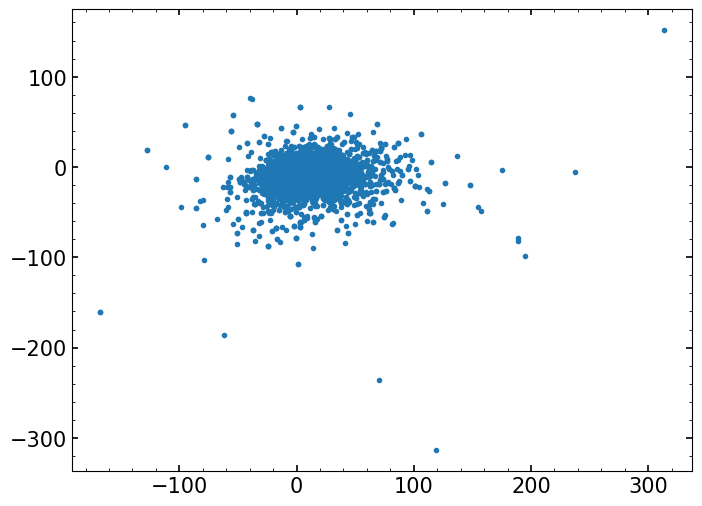

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(l12_m31_g3["pmra"], l12_m31_g3["pmdec"], '.')

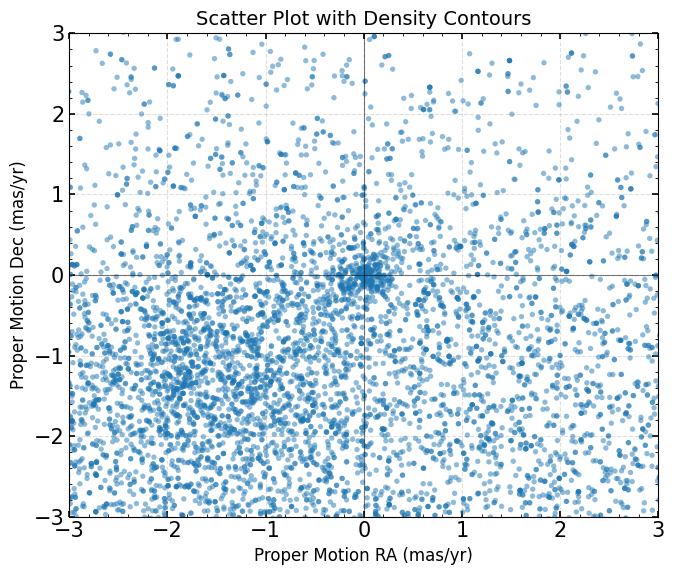

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# set_cham(latex=False)

pmra,pmdec = l12_m31_g3["pmra"], l12_m31_g3["pmdec"]

# 创建画布
fig, ax = plt.subplots(figsize=(7, 6))

# 1. 绘制散点图（半透明显示）
scatter = ax.scatter(
    pmra, pmdec,
    s=15,                # 点大小
    alpha=0.5,           # 透明度（避免遮挡等高线）
    c='tab:blue',       # 统一颜色
    edgecolors='none',   # 无描边
    zorder=2             # 确保散点在等高线上方[1](@ref)
)

# 2. 美化设置
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel("Proper Motion RA (mas/yr)", fontsize=12)
ax.set_ylabel("Proper Motion Dec (mas/yr)", fontsize=12)
ax.set_title("Scatter Plot with Density Contours", fontsize=14)
ax.grid(ls='--', alpha=0.4)  # 虚线网格
ax.axhline(0, color='k', lw=0.8, alpha=0.5)  # 赤纬0参考线
ax.axvline(0, color='k', lw=0.8, alpha=0.5)  # 赤经0参考线

plt.tight_layout()
plt.show()

### 对M31自行的预期

将仙女座星系（M31）的旋转曲线（描述其内部物质随半径变化的旋转速度）折算为自行（Proper Motion）数据，本质是将物理速度（km/s）转换为角速度（mas/yr）。这一过程需结合M31的几何参数、距离和观测几何进行投影计算。

从旋转曲线折算自行的核心公式为：

$$\boxed{\mu = \dfrac{V_{\text{rot}} \cdot \sin i}{4.74 \cdot D}}$$

我们按照 $$V_\textrm{rot}=220\,\textrm{km/s}$$, $$D=785\,\textrm{kpc}$$

忽略 $\sin{i}$ 可得，$$\mu<\frac{220}{4.74 \times 785}\approx 0.059 \,\text{mas/yr}$$

而GAIA对M31区域典型的测量误差也在 $0.05\,\text{mas/yr}$

因此，我们可以将自行小于 $0.1\text{mas/yr}$ 作为判据对样本进行第二次筛选

In [11]:
pm = np.sqrt(l12_m31_g3["pmra"]**2+l12_m31_g3["pmdec"]**2)

PM_MAX = 0.5

idx_pm = (pm<PM_MAX) & np.logical_not(pm.mask)
print(np.sum(pm<PM_MAX))
# 筛选得到466个源
l12_m31_g3_pm = l12_m31_g3[idx_pm]
l12_m31_g3_pm.write("m31/lamost/l12_m31_gedr3_pm0.5.fits", overwrite=True)
print(len(l12_m31_g3_pm))

414
414


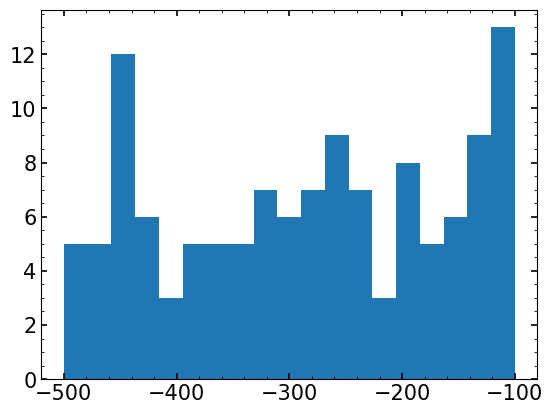

In [15]:
# 快速查看一下他们的视向速度分布
plt.hist(l12_m31_g3_pm["z"]*299792.458, bins=np.linspace(-500, -100, 20));

### 看起来样本还需要更细节的分析